# Covid 19 Predictors Analysis

This notebook analysis how combinations of bio-data, risk factors and pre-existing conditions contribute to COVID-19 diagnosis. The dataset is sourced from the Mexican Ministry of Health, accessed October 2025.

- Dataset (Mexican Government): https://www.gob.mx/salud/documentos/datos-abiertos-152127
- Reference paper: https://pmc.ncbi.nlm.nih.gov/articles/PMC8646298/

## Feature Encoding

- Binary features: 1 = Yes, 2 = No
- Pregnancy: 1 = Yes, 2 = No, 97 = N/A (males)
- Missing values / Not Specified: 98, 99

## Data Exploration

Read CSV and display column information.

In [1]:
import pandas as pd
from pathlib import Path

In [2]:
from shared import load_csv

df = load_csv(dataset="COVID19MEXICO.csv")
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129177 entries, 0 to 129176
Data columns (total 42 columns):
 #   Column                     Non-Null Count   Dtype 
---  ------                     --------------   ----- 
 0   FECHA_ACTUALIZACION        129177 non-null  object
 1   ID_REGISTRO                129177 non-null  object
 2   ORIGEN                     129177 non-null  int64 
 3   SECTOR                     129177 non-null  int64 
 4   ENTIDAD_UM                 129177 non-null  int64 
 5   SEXO                       129177 non-null  int64 
 6   ENTIDAD_NAC                129177 non-null  int64 
 7   ENTIDAD_RES                129177 non-null  int64 
 8   MUNICIPIO_RES              129177 non-null  int64 
 9   TIPO_PACIENTE              129177 non-null  int64 
 10  FECHA_INGRESO              129177 non-null  object
 11  FECHA_SINTOMAS             129177 non-null  object
 12  FECHA_DEF                  129177 non-null  object
 13  INTUBADO                   129177 non-null  

These columns need both translating and filtering, let's create a function for that!

In [3]:
from shared import translate_filter_columns

# inlcude leaky features, only included for exploratory analysis
df, col_names = translate_filter_columns(df, optional_includes=["pcr_result", "death_date"])

In [4]:
df[["pregnant"]].value_counts()

pregnant
2           70055
97          57233
1            1662
98            227
Name: count, dtype: int64

In [5]:
df.head()

,sex,pneumonia,age,pregnant,diabetes,copd,asthma,immunosuppressed,hypertension,other_comorbidity,cardiovascular_disease,obesity,chronic_kidney_disease,smoking,contact_with_covid_case,covid_classification,pcr_result,death_date
0,2,2,8,97,2,2,2,2,2,2,2,2,2,2,2,6,997,9999-99-99
1,2,2,26,97,2,2,2,2,2,2,2,2,2,2,2,6,997,9999-99-99
2,1,2,57,2,2,2,2,2,2,1,2,1,2,2,2,6,997,9999-99-99
3,1,2,2,2,2,2,1,1,2,2,2,2,2,2,2,7,3,9999-99-99
4,1,2,86,2,2,2,2,2,2,2,2,2,2,2,2,7,5,9999-99-99


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129177 entries, 0 to 129176
Data columns (total 18 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   sex                      129177 non-null  int64 
 1   pneumonia                129177 non-null  int64 
 2   age                      129177 non-null  int64 
 3   pregnant                 129177 non-null  int64 
 4   diabetes                 129177 non-null  int64 
 5   copd                     129177 non-null  int64 
 6   asthma                   129177 non-null  int64 
 7   immunosuppressed         129177 non-null  int64 
 8   hypertension             129177 non-null  int64 
 9   other_comorbidity        129177 non-null  int64 
 10  cardiovascular_disease   129177 non-null  int64 
 11  obesity                  129177 non-null  int64 
 12  chronic_kidney_disease   129177 non-null  int64 
 13  smoking                  129177 non-null  int64 
 14  contact_with_covid_c

In [7]:
# 1: Female, 2: Male
df["sex"].value_counts()

sex
1    71944
2    57233
Name: count, dtype: int64

In [8]:
# 97: N/A
df.columns[df.isin([97]).any()]

Index(['age', 'pregnant'], dtype='object')

Of course, N/A is only relevant here for pregnancy, and is present for all male records. Let's look at the boolean feature distributions:

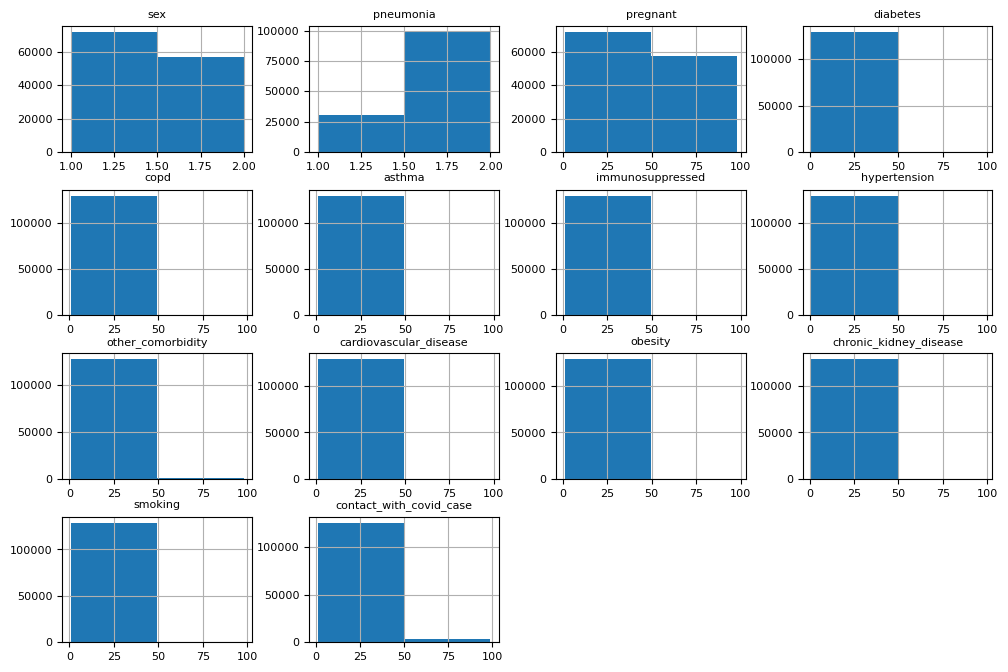

In [9]:
import matplotlib.pyplot as plt

plt.rc("font", size=5)
plt.rc("axes", titlesize=8)
plt.rc("xtick", labelsize=8)
plt.rc("ytick", labelsize=8)

binary_features = [
        "sex", "pneumonia", "pregnant", "diabetes", 
        "copd", "asthma", "immunosuppressed", "hypertension", "other_comorbidity", 
        "cardiovascular_disease", "obesity", "chronic_kidney_disease", "smoking", "contact_with_covid_case", 
    ]

df[binary_features].hist(bins=2, figsize=(12, 8))

plt.show()

In [10]:
import numpy as np

max_age = df["age"].max()
bins = np.arange(0, max_age + 5, 5)
binned = pd.cut(df["age"], bins=bins, right=False)
counts = binned.value_counts().sort_index()

print(counts.to_string())

age
[0, 5)        20102
[5, 10)        8711
[10, 15)       5801
[15, 20)       4903
[20, 25)       7350
[25, 30)       9592
[30, 35)       9172
[35, 40)       7663
[40, 45)       7196
[45, 50)       6903
[50, 55)       7256
[55, 60)       6649
[60, 65)       5771
[65, 70)       5524
[70, 75)       4618
[75, 80)       4167
[80, 85)       3403
[85, 90)       2573
[90, 95)       1289
[95, 100)       422
[100, 105)       97
[105, 110)       12
[110, 115)        2
[115, 120)        0
[120, 125)        1


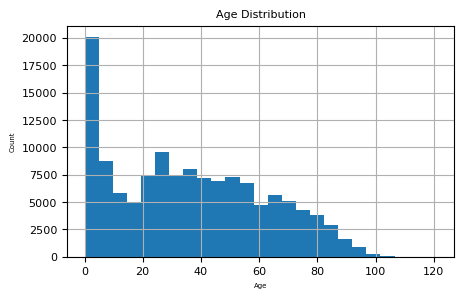

In [11]:
df[["age"]].hist(bins=25, figsize=(5, 3))
plt.title("Age Distribution")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

In [12]:
# 99s
df["contact_with_covid_case"].value_counts()

contact_with_covid_case
2     102556
1      23114
99      3507
Name: count, dtype: int64

The `"contact_with_covid_case"` is the only feature with categorical values of 99, we can assume these represent missing / non-specified values. We can deal with them in our transformation pipeline accordiningly. 

In [13]:
df["covid_classification"].value_counts()

covid_classification
7    72581
6    47142
3     6956
5     2438
4       60
Name: count, dtype: int64

The target label spans a range of values. Despite scouring through various research papers and online sources, I cannot find a definition or data catalogue for the target label values. So let's cross-reference this label with `pcr_result` and `pneumonia` rates (it stands to reason there could be correlation here). Let's also analyse the mortality rates for each classification.

In [14]:
df.groupby("covid_classification")["pcr_result"].describe()

,count,mean,std,min,25%,50%,75%,max
covid_classification,,,,,,,,
3,6956.0,33.939620,1.378517,1.0,34.0,34.0,34.0,34.0
4,60.0,8.200000,6.693787,6.0,6.0,6.0,6.0,33.0
5,2438.0,17.000000,0.000000,17.0,17.0,17.0,17.0,17.0
6,47142.0,997.085996,0.405708,997.0,997.0,997.0,997.0,999.0
7,72581.0,5.834860,5.178081,1.0,5.0,5.0,5.0,37.0


In [15]:
df.groupby("covid_classification")["pneumonia"].apply(lambda x: x.map({1: "yes", 2: "no"}).value_counts())

covid_classification     
3                     no      5483
                      yes     1473
4                     yes       32
                      no        28
5                     no      1725
                      yes      713
6                     no     45781
                      yes     1361
7                     no     45801
                      yes    26780
Name: pneumonia, dtype: int64

In [16]:
df.groupby("covid_classification").apply(lambda x: (x["death_date"] != "9999-99-99").sum())

/var/folders/jt/mxzgbwzn48j2hh6k2hy3w6bh0000gn/T/ipykernel_62024/2693911628.py:1: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("covid_classification").apply(lambda x: (x["death_date"] != "9999-99-99").sum())


covid_classification
3     361
4       2
5     130
6     194
7    4164
dtype: int64

In [17]:
df.groupby("covid_classification").apply(
    lambda x: (x["death_date"] != "9999-99-99").sum() / len(x),
    include_groups=False
)

covid_classification
3    0.051898
4    0.033333
5    0.053322
6    0.004115
7    0.057370
dtype: float64

In [18]:
df = df.drop("death_date", axis=1)

Plotting feature distribution of covid classifications across `age` may also reveal more information.

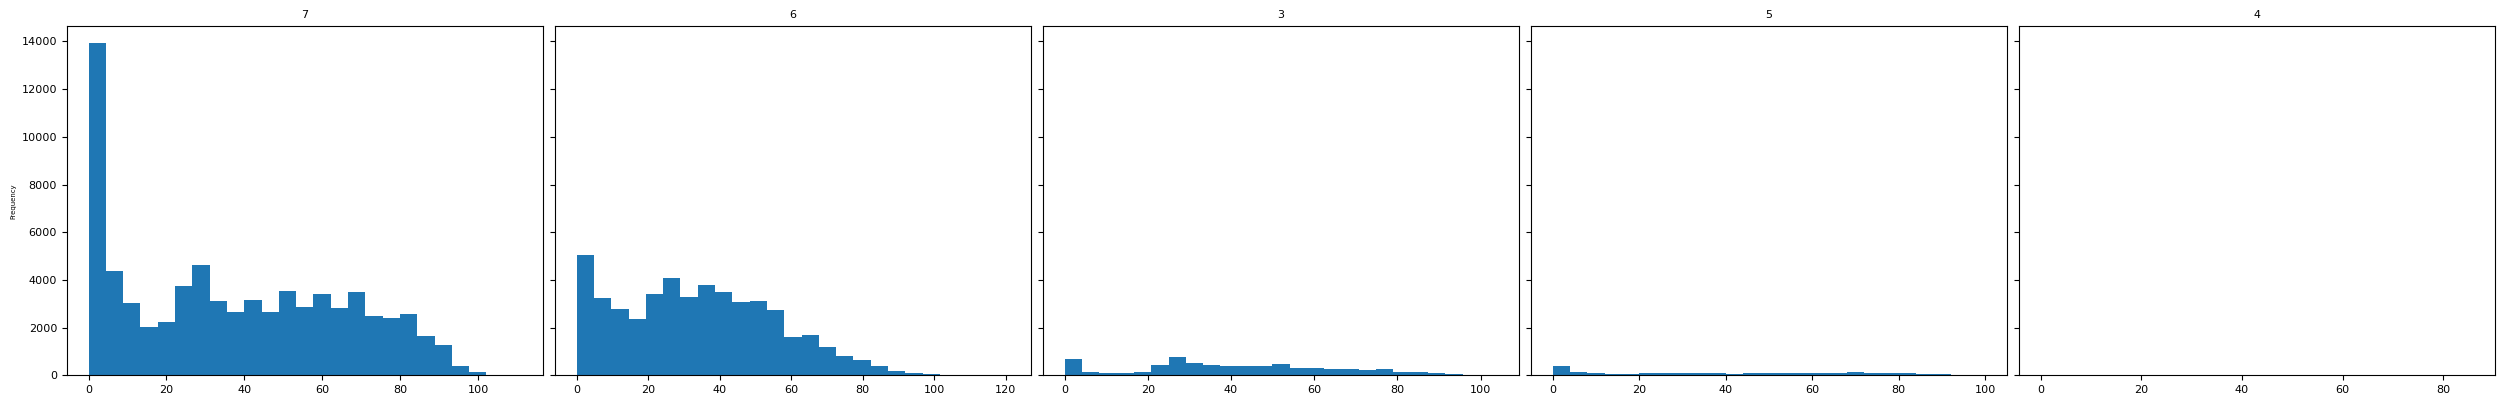

In [19]:
classes = df["covid_classification"].value_counts().index
fig, axes = plt.subplots(1, len(classes), figsize=(5 * len(classes), 4), sharey=True)

for ax, cls in zip(axes, classes):
    df[df["covid_classification"] == cls]["age"].plot.hist(bins=25, ax=ax, title=f"{cls}")

plt.tight_layout()
plt.show()

We'll likely need to train the classifier and reverse-engineer the labels from the feature patterns, correlating those with our findings here. But what have we found here? Well, the analysis reveals a few things:

- Classes 3, 5 and 7 maintain around ~5% mortality rates (5.19%, 5.33%, 5.74%), with PCR values consistent with positive cases.
- Class 6 shows 0.41% mortality, with PCR codes 997 and 999 (negative? N/A?).
- Class 6 is likely negative, and class 4, with very few instances, can be dropped as its inconclusive.

We could treat classes 3, 5 and 7 as positive labels, and 6 as negative, but we'll see what further classifier analysis reveals.

Let's now check the percentage of rows in the dataset with absent values.

In [20]:
# replace explicit missing values with NaN
df_clean = df.replace([98, 99], np.nan)

# count those rows
missing_count = df_clean.isna().any(axis=1).sum()
print(f"Missing data across: {missing_count} rows")
print(f"Approximately {(missing_count / df_clean.shape[0]) * 100:.2f}% of the dataset")

# count per column
missing_counts = df_clean.isna().sum()
print(missing_counts)

Missing data across: 4968 rows
Approximately 3.85% of the dataset
sex                           0
pneumonia                     0
age                         101
pregnant                    227
diabetes                    164
copd                        170
asthma                      166
immunosuppressed            116
hypertension                114
other_comorbidity          1023
cardiovascular_disease      126
obesity                     110
chronic_kidney_disease      113
smoking                     153
contact_with_covid_case    3507
covid_classification          0
pcr_result                    0
dtype: int64


These rows can be dropped. Some features are likely correlated, for example, gender and pregnancy. Let's take a look at a correlation matrix.

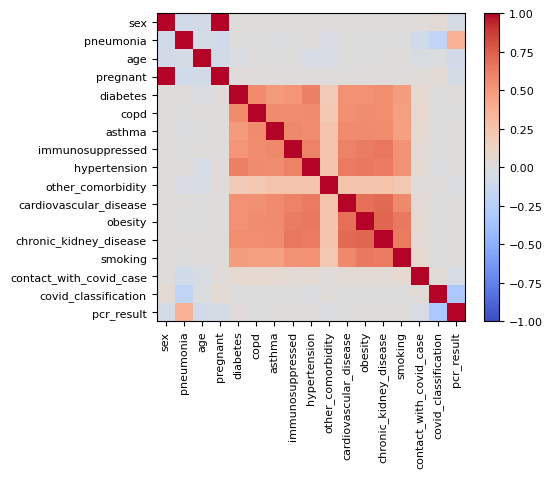

In [21]:
corr = df.corr()

fig, ax = plt.subplots(figsize=(5, 4))

cax = ax.imshow(corr, cmap="coolwarm", vmin=-1, vmax=1)
fig.colorbar(cax)

# ticks and labels
ax.set_xticks(np.arange(len(corr.columns)))
ax.set_yticks(np.arange(len(corr.columns)))

ax.set_xticklabels(corr.columns, rotation=90)
ax.set_yticklabels(corr.columns)

plt.show()

## Observations

- Some features have skewed distributions:
  - `Age` (continous) is right-skewed, values range through 0 to 120.
  - Binary features mostly represent medical conditions only few are likely to have.
- Absent values: Some may be MCAR (however, it's likely fields such as `contact_with_covid_case` are likely MNAR), but they make up < 4% of the dataset size.
- Encoding: The binary indicators can likely be re-encoded for interpretability, though its not strictly necessary.
- Moderate colinearity exists, between various pre-existing conditions for example.

## Preprocessing Strategy and Modelling Approach

1. Rename and filter columns.
2. Drop rows containing absent values (4968 rows).
3. Drop class 4.
4. Combine classes for binary classification.
5. Extract train/test split (dropping ages of only 1 member).
6. Remap binary features (2 -> 0) for interpretability. For the `pregancy` column, maintain 3 values (1 = Yes, 0 = No) and remap 97 -> 2 (N/A).

> We'll (tentatively) consider classes 3, 5 and 7 as positive, and 6 as negative based on mortality analysis. However, we'll train a multiclass classifier initially to confirm these labels through feature importance patterns.

Given the observations, decision tree and ensemble based models are likely best because: 
- They're interpretable models (which are great for building symbolic clinical rules).
- They're robust against colinearity and skewed distributions.
- There will be minimal preprocessing required (less feature encoding for boolean indicators or scaling for age).